In [430]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Polygon, Patch
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from scipy import ndimage, interpolate

In [452]:
yr_start = 2020
step_yr=1
years=np.arange(yr_start,2101,step_yr)
years

array([2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030,
       2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041,
       2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052,
       2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063,
       2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074,
       2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085,
       2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096,
       2097, 2098, 2099, 2100])

In [453]:
# Define GMT scenarios

scens = ["Ref1.5", "PW1.65", "SA1.65", "PW1.8"]

PW = 1.65
W_2020 = 1.2
yr_15_befov = 2040
yr_PW = 2060
yr_15_aftov = 2080

GMT=np.zeros((len(scens),len(years)))

for sc in range(len(scens)):
    for i in range(len(years)):
        if years[i] <= yr_15_befov:
            GMT[sc,i] = 1.5 - (yr_15_befov-years[i])*(1.5-W_2020)/(yr_15_befov-2020)
        if years[i] > yr_15_befov and years[i] <= yr_PW:
            if scens[sc] == "Ref1.5": 
                GMT[sc,i] = 1.5
            elif scens[sc] == "PW1.65" or scens[sc] == "SA1.65":
                GMT[sc,i] = PW - (yr_PW-years[i])*(PW-1.5)/(yr_PW-yr_15_befov)
            elif scens[sc] == "PW1.8":
                GMT[sc,i] = 1.8 - (yr_PW-years[i])*(1.8-1.5)/(yr_PW-yr_15_befov)
        elif years[i] > yr_PW and years[i] <= yr_15_aftov:
            if scens[sc] == "Ref1.5": 
                GMT[sc,i] = 1.5
            elif scens[sc] == "PW1.65":
                GMT[sc,i] = PW - (years[i]-yr_PW)*(PW-1.5)/(yr_15_aftov-yr_PW)
            elif scens[sc] == "SA1.65":
                GMT[sc,i] = 1.65
            elif scens[sc] == "PW1.8":
                GMT[sc,i] = 1.8 - (years[i]-yr_PW)*(1.8-1.5)/(yr_15_aftov-yr_PW)
        elif years[i] > 2060:
            if scens[sc] == "PW1.65" or scens[sc] == "Ref1.5":
                GMT[sc,i] = 1.5
            elif scens[sc] == "SA1.65":
                GMT[sc,i] = 1.65
            elif scens[sc] == "PW1.8":
                GMT[sc,i] = 1.5

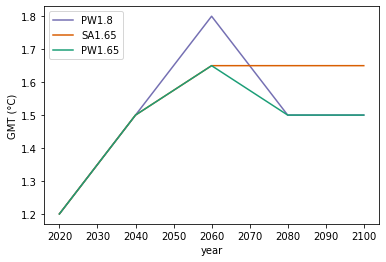

In [470]:
# Plot the GMT trajectories

# colors from https://colorbrewer2.org/#type=qualitative&scheme=Dark2&n=3

plt.plot(years,GMT[3,:], color='#7570b3', label='PW1.8')
plt.plot(years,GMT[2,:], color='#d95f02', label='SA1.65')
plt.plot(years,GMT[1,:], color='#1b9e77', label='PW1.65')
#plt.plot(years,GMT[0,:], color='k')
    
plt.xlabel('year')
plt.ylabel('GMT (°C)')
plt.legend(loc='upper left')
plt.show()

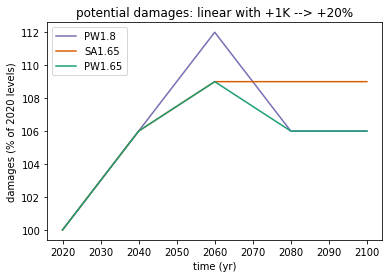

In [509]:
# Plot the relative change in damages from Global Warming if there is no adaptation

# Define damage coefficients from global warming
# assuming a linear increase in damages with GW, with +1K leading to +20% damages
dam_coeff = 100 + (GMT-GMT[0,0])*20 # damages linear with GW, +1K brings +20% damages

# plot damages
plt.figure()

plt.plot(years,dam_coeff[3,:], color='#7570b3', label='PW1.8')
plt.plot(years,dam_coeff[2,:], color='#d95f02', label='SA1.65')
plt.plot(years,dam_coeff[1,:], color='#1b9e77', label='PW1.65')
#plt.plot(years,dam_coeff[0,:], color='C0')
    
plt.title('potential damages: linear with +1K --> +20%')
plt.xlabel('time (yr)')
plt.ylabel('damages (% of 2020 levels)')
plt.legend(loc='upper left')
plt.show()

In [510]:
# When reaching 1.5°C in 2040, and knowing that there would be an overshoot of 40 years:
# do we rather want to adapt to 1.5°C or to the peak warming during the length of the overshoot?
# Assuming: 
# - that damages evolve linearly with GW
# - that the percentage of impact reduction is the same at each wind intensity. i.e., spending X% of potential damages on adaptation at 1.5C (resp., Peak Warming) will avoid Y% of potential damages to be expected at 1.5C (resp., Peak Warming)

# Calculate the total costs = costs of adaptation + potential damages - damages avoided via adaptation
# and test sensitivity with various parameters: discount rate, economic growth, cost and effectiveness of adaptation option

# not accounted for: costs of re-building and re-adapting

# We're looking at damages from a 1-in-100-year event
p_ev = 0.01


# Range of parameters to scan in the sensitivity analysis
disc_rate = np.arange(0.,6.,2)  # time discounting rate
ec_growth = np.arange(0.,6.,2)  # economic growth
perc_av_dam = range(10,110,10)  # Percentage of the damages avoided through adaptation
adcosts_perc_dam = range(5,35,5)  # adaptation costs (expressed as a percentage of the damages)


adcosts = np.empty([2,len(scens)])
dam = np.empty([len(scens),len(disc_rate),len(ec_growth),len(years)])
av_dam = np.empty([2,len(scens),len(disc_rate),len(ec_growth),len(years)])
net_dam = np.empty([2,len(scens),len(disc_rate),len(ec_growth),len(years)])
tot_dam = np.empty([2,len(scens),len(disc_rate),len(ec_growth)])
ratio_costs_options = np.empty([len(scens),len(disc_rate),len(ec_growth),len(perc_av_dam),len(adcosts_perc_dam)])


#Debugging#
A = np.empty([2,len(scens),len(disc_rate),len(ec_growth),len(perc_av_dam),len(years)])
B = np.empty([2,len(scens),len(disc_rate),len(ec_growth),len(perc_av_dam),len(years)])
#Debugging#

for di in range(len(disc_rate)):
    
    #print('discount rate')
    #print(disc_rate[di])
    
    for gr in range(len(ec_growth)):
        
        #print('growth')
        #print(ec_growth[gr])
        
        for avd in range(len(perc_av_dam)):
            
            #print('avoided damages (%)')
            #print(perc_av_dam[avd])
            
            for adc in range(len(adcosts_perc_dam)):

                # Costs of adaptation
                ## Option 1: Costs of adapting to damage level at GMT = 1.5°C
                adcosts[0,:] = np.squeeze(adcosts_perc_dam[adc]/100*dam_coeff[:,np.where(years==yr_15_befov)[0]])
    
                ## Option 2: Costs of adapting to damage level at Peak Warming
                adcosts[1,:] = np.squeeze(adcosts_perc_dam[adc]/100*dam_coeff[:,np.where(years==yr_PW)[0]])

            
                for yr in range(int(np.where(years==yr_15_befov+1)[0]),int(np.where(years==yr_15_aftov+1)[0]),step_yr):

                    #print(years[yr])
                    
                    # Damages in case of an event, taking both the time discounting rate and economic growth into account
                    dam[:,di,gr,yr] = dam_coeff[:,yr]*((1-disc_rate[di]/100)*(1+ec_growth[gr]/100))**(years[yr]-yr_15_befov)           
                
                
                    # Damages avoided through adaptation in case of an event, taking the time discounting rate into account
                    ## Option 1: when adaptating to damage level at GMT = 1.5°C
                    av_dam[0,:,di,gr,yr] = np.squeeze(perc_av_dam[avd]/100*dam_coeff[:,np.where(years==yr_15_befov)[0]]*((1-disc_rate[di]/100)*(1+ec_growth[gr]/100))**(years[yr]-yr_15_befov))
                        
                    #DEBUGGING
                    A[0,:,di,gr,avd,yr] = av_dam[0,:,di,gr,yr]
        
                    ## Option 2: when adaptating to damage level at Peak Warming
                    av_dam[1,:,di,gr,yr] = np.squeeze(perc_av_dam[avd]/100*dam_coeff[:,np.where(years==yr_PW)[0]]*((1-disc_rate[di]/100)*(1+ec_growth[gr]/100))**(years[yr]-yr_15_befov))
                       
                    #DEBUGGING
                    A[1,:,di,gr,avd,yr] = av_dam[1,:,di,gr,yr]
        
                
                    # Expected net damages (damages - damages avoided through adaptation) if event happens in year yr and hasn't happened before
                       
                    for sc in range(len(scens)):
                            
                        ## Option 1: when adaptating to damage level at GMT = 1.5°C
                        net_dam[0,sc,di,gr,yr] = max((1-p_ev)**(yr-int(np.where(years==yr_15_befov+1)[0]))*p_ev*(dam[sc,di,gr,yr]-av_dam[0,sc,di,gr,yr]),0)
                
                        ## Option 2: when adaptating to damage level at Peak Warming
                        net_dam[1,sc,di,gr,yr] = max((1-p_ev)**(yr-int(np.where(years==yr_15_befov+1)[0]))*p_ev*(dam[sc,di,gr,yr]-av_dam[1,sc,di,gr,yr]),0) 
                        
                    #DEBUGGING
                    B[0,:,di,gr,avd,yr] = net_dam[0,:,di,gr,yr]
                    B[1,:,di,gr,avd,yr] = net_dam[1,:,di,gr,yr]
                    
    
                # Total expected damages for 2041-2080 in case one event happens during that period
                ## Option 1: when adaptating to damage level at GMT = 1.5°C
                tot_dam[0,:,di,gr] = np.sum(net_dam[0,:,di,gr,int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])],1)
    
                ## Option 2: when adaptating to damage level at Peak Warming
                tot_dam[1,:,di,gr] = np.sum(net_dam[1,:,di,gr,int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])],1)
        
        
                # Calculate ratio of total costs (net damages + costs of adaptation) when adapting to 1.5°C over total costs when adapting to Peak Warming            
                ratio_costs_options[:,di,gr,avd,adc] = (tot_dam[0,:,di,gr] + adcosts[0,:]) / (tot_dam[1,:,di,gr] + adcosts[1,:])                                  

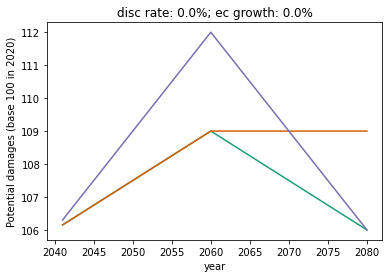

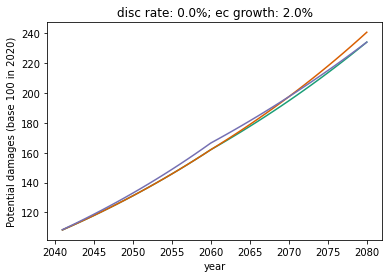

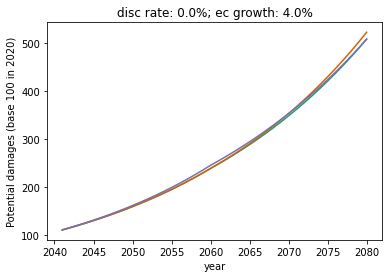

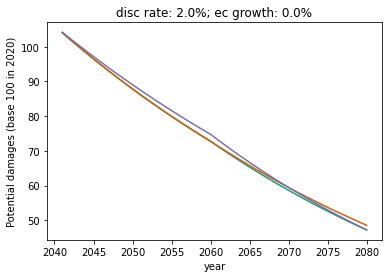

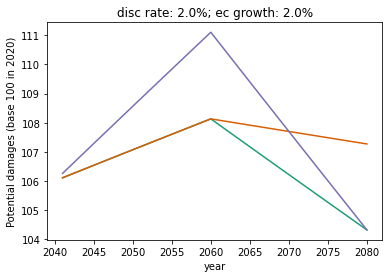

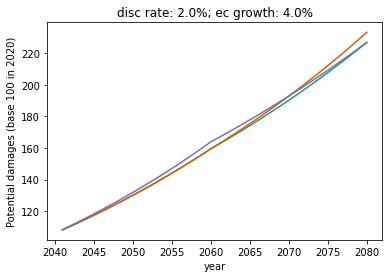

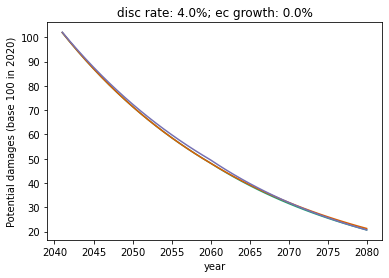

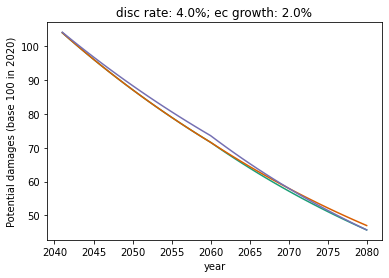

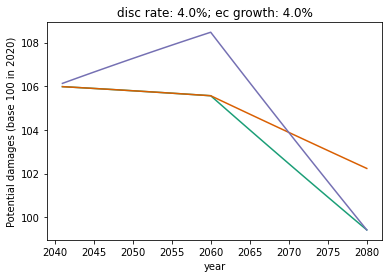

In [461]:
# Plot the potential damages over time

for di in range(len(disc_rate)):
    for gr in range(len(ec_growth)):

        plt.figure()

        #plt.plot(years[int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])],dam[0,di,gr,int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])], color='C0')
        plt.plot(years[int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])],dam[1,di,gr,int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])], color='#1b9e77')
        plt.plot(years[int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])],dam[2,di,gr,int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])], color='#d95f02')
        plt.plot(years[int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])],dam[3,di,gr,int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])], color='#7570b3')
    
        plt.title('disc rate: '+str(disc_rate[di])+'%; ec growth: '+str(ec_growth[gr])+'%')
        plt.xlabel('year')
        plt.ylabel('Potential damages (base 100 in 2020)')
        plt.show()

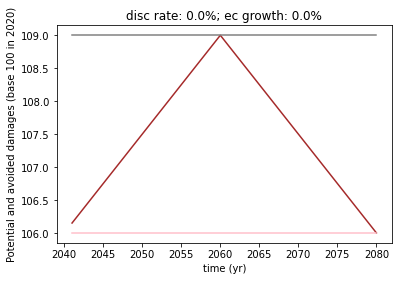

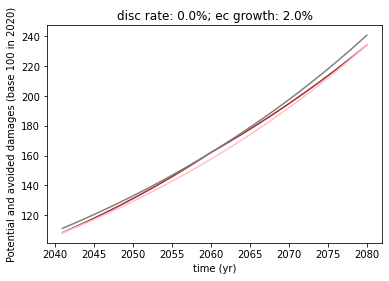

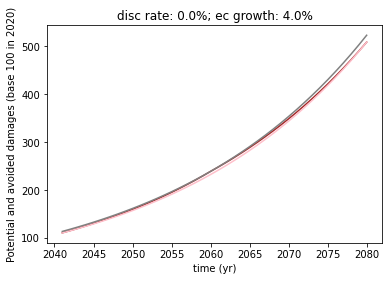

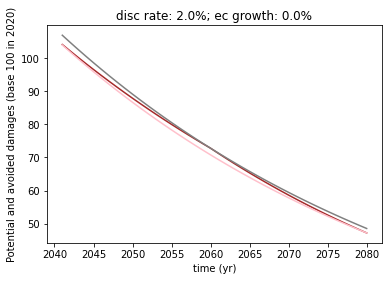

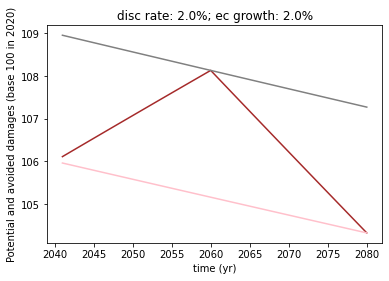

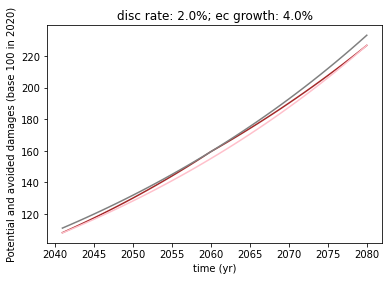

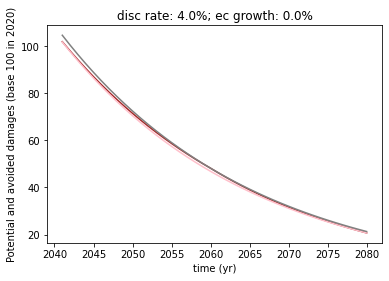

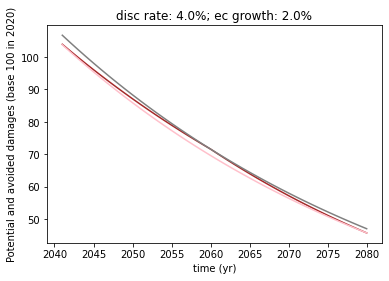

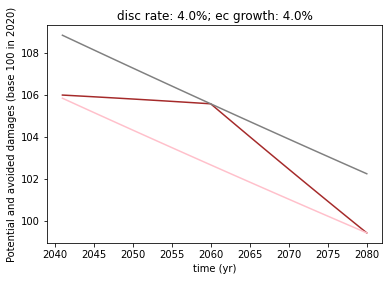

In [494]:
#DEBUGGING
# Plot the potential and avoided damages over time

sc=1
avd=9

for di in range(len(disc_rate)):
    for gr in range(len(ec_growth)):

        plt.figure()

        plt.plot(years[int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])],dam[sc,di,gr,int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])], color='brown')
        plt.plot(years[int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])],A[0,sc,di,gr,avd,int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])], color='pink')
        plt.plot(years[int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])],A[1,sc,di,gr,avd,int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])], color='grey')
    
        plt.title('disc rate: '+str(disc_rate[di])+'%; ec growth: '+str(ec_growth[gr])+'%')
        plt.xlabel('time (yr)')
        plt.ylabel('Potential and avoided damages (base 100 in 2020)')
        plt.show()

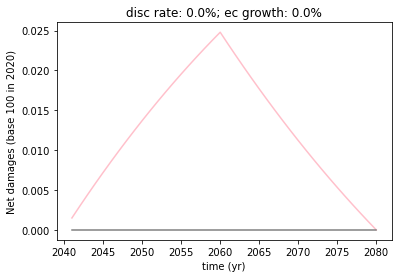

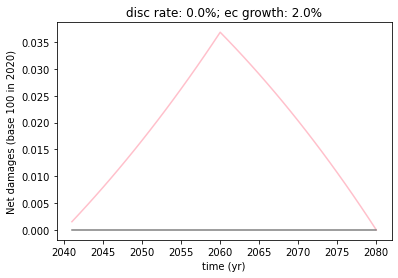

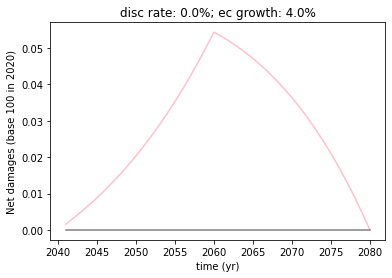

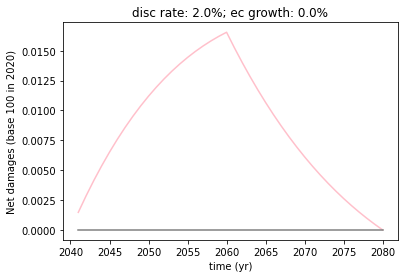

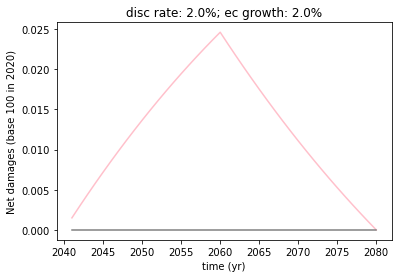

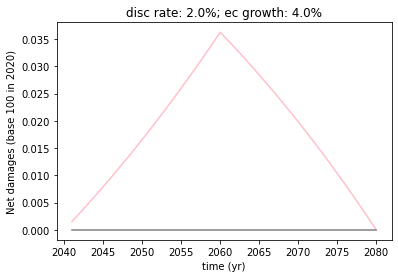

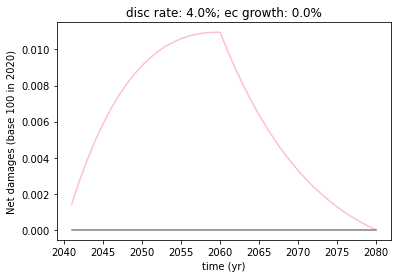

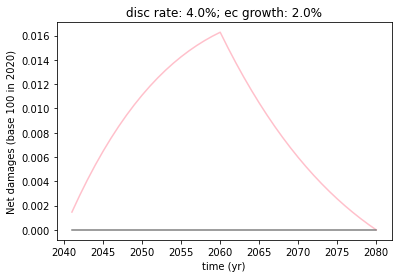

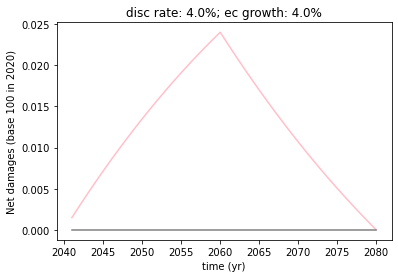

In [500]:
#DEBUGGING
# Plot the net damages over time

sc=1
avd=9

for di in range(len(disc_rate)):
    for gr in range(len(ec_growth)):

        plt.figure()

        plt.plot(years[int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])],B[0,sc,di,gr,avd,int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])], color='pink')
        plt.plot(years[int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])],B[1,sc,di,gr,avd,int(np.where(years==yr_15_befov+1)[0]):int(np.where(years==yr_15_aftov+1)[0])], color='grey')
    
        plt.title('disc rate: '+str(disc_rate[di])+'%; ec growth: '+str(ec_growth[gr])+'%')
        plt.xlabel('time (yr)')
        plt.ylabel('Net damages (base 100 in 2020)')
        plt.show()

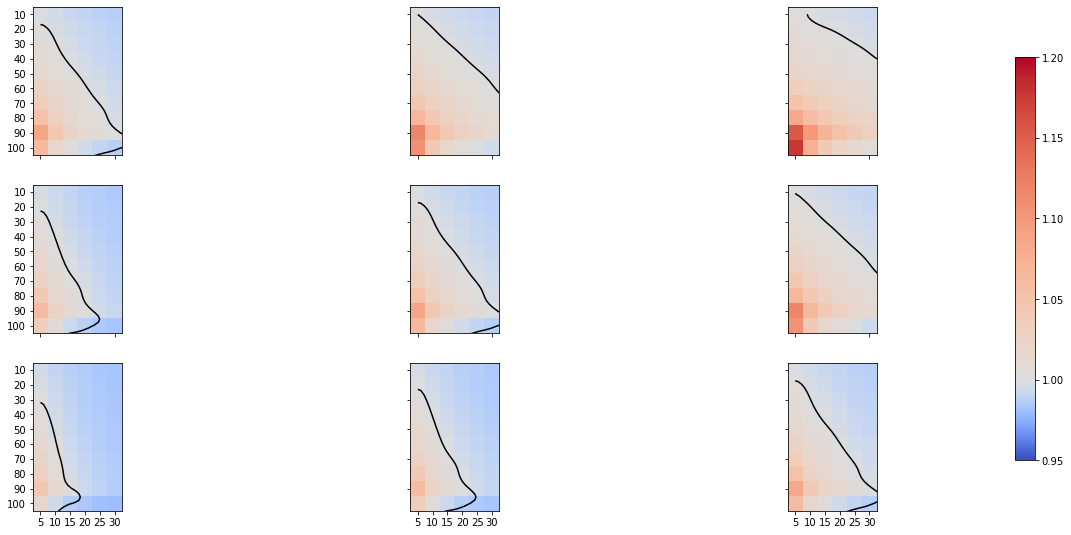

In [467]:
# Plot the ratio of total costs for the various values of the parameters investigated
# discount rates, damage level avoided through adaptation, costs of adaptation


# Define colorbar
colors1 = plt.cm.coolwarm(np.linspace(0, 1, 40))[:20]
colors2 = plt.cm.coolwarm(np.linspace(0, 1, 160))[-80:]
my_cmap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', np.vstack((colors1,colors2)))


## For the PW1.65 scenario

axes=[]
fig=plt.figure(figsize=(18,7))

xticklabels = []
for adc in range(len(adcosts_perc_dam)):
    xticklabels.append(str(adcosts_perc_dam[adc]))
    
yticklabels = []
for avd in range(len(perc_av_dam)):
    yticklabels.append(str(perc_av_dam[avd]))

    
smooth_scale = 5

for di in range(len(disc_rate)):
    for gr in range(len(ec_growth)):

        axes.append(fig.add_subplot(len(disc_rate), len(ec_growth), di*(len(ec_growth))+gr+1))
        
        z = ndimage.zoom(ratio_costs_options[1,di,gr,:,:], smooth_scale)
        cntr = plt.contour(np.linspace(0, len(adcosts_perc_dam), len(adcosts_perc_dam) * smooth_scale), 
                   np.linspace(0, len(perc_av_dam), len(perc_av_dam) * smooth_scale),
                   z, levels=(0.5,1), colors = 'black')
        
        ax = plt.imshow(ratio_costs_options[1,di,gr,:,:],cmap=my_cmap,vmin=0.95,vmax=1.2)

        if di != len(disc_rate)-1:
            ax.axes.xaxis.set_ticklabels([])
        else:
            plt.xticks(np.arange(len(adcosts_perc_dam)),xticklabels)
            
        if gr != 0:
            ax.axes.yaxis.set_ticklabels([])
        else:
            plt.yticks(np.arange(len(perc_av_dam)),yticklabels)
        

plt.subplots_adjust(bottom=0., right=0.95, top=1.0)
cax = plt.axes([0.97, 0.1, 0.015, 0.8])
plt.colorbar(cax=cax)



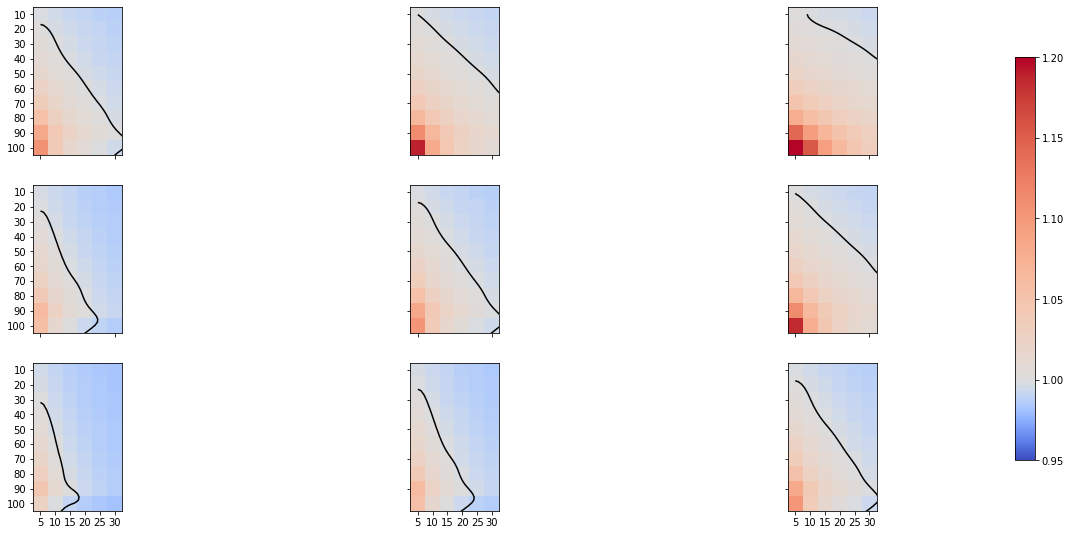

In [11]:
# Plot the ratio of total costs for the various values of the parameters investigated
# discount rates, damage level avoided through adaptation, costs of adaptation


# Define colorbar
colors1 = plt.cm.coolwarm(np.linspace(0, 1, 40))[:20]
colors2 = plt.cm.coolwarm(np.linspace(0, 1, 160))[-80:]
#n_sections = 100
my_cmap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', np.vstack((colors1,colors2)))#, N=n_sections)


## For the 'SA1.65' scenario

axes=[]
fig=plt.figure(figsize=(18,7))

xticklabels = []
for adc in range(len(adcosts_perc_dam)):
    xticklabels.append(str(adcosts_perc_dam[adc]))
    
yticklabels = []
for avd in range(len(perc_av_dam)):
    yticklabels.append(str(perc_av_dam[avd]))

    
smooth_scale = 5

for di in range(len(disc_rate)):
    for gr in range(len(ec_growth)):

        axes.append(fig.add_subplot(len(disc_rate), len(ec_growth), di*(len(ec_growth))+gr+1))
        
        z = ndimage.zoom(ratio_costs_options[2,di,gr,:,:], smooth_scale)
        cntr = plt.contour(np.linspace(0, len(adcosts_perc_dam), len(adcosts_perc_dam) * smooth_scale), 
                   np.linspace(0, len(perc_av_dam), len(perc_av_dam) * smooth_scale),
                   z, levels=(0.5,1), colors = 'black')
        
        ax = plt.imshow(ratio_costs_options[2,di,gr,:,:],cmap=my_cmap,vmin=0.95,vmax=1.2)

        if di != len(disc_rate)-1:
            ax.axes.xaxis.set_ticklabels([])
        else:
            plt.xticks(np.arange(len(adcosts_perc_dam)),xticklabels)
            
        if gr != 0:
            ax.axes.yaxis.set_ticklabels([])
        else:
            plt.yticks(np.arange(len(perc_av_dam)),yticklabels)
        

plt.subplots_adjust(bottom=0., right=0.95, top=1.0)
cax = plt.axes([0.97, 0.1, 0.015, 0.8])
plt.colorbar(cax=cax)



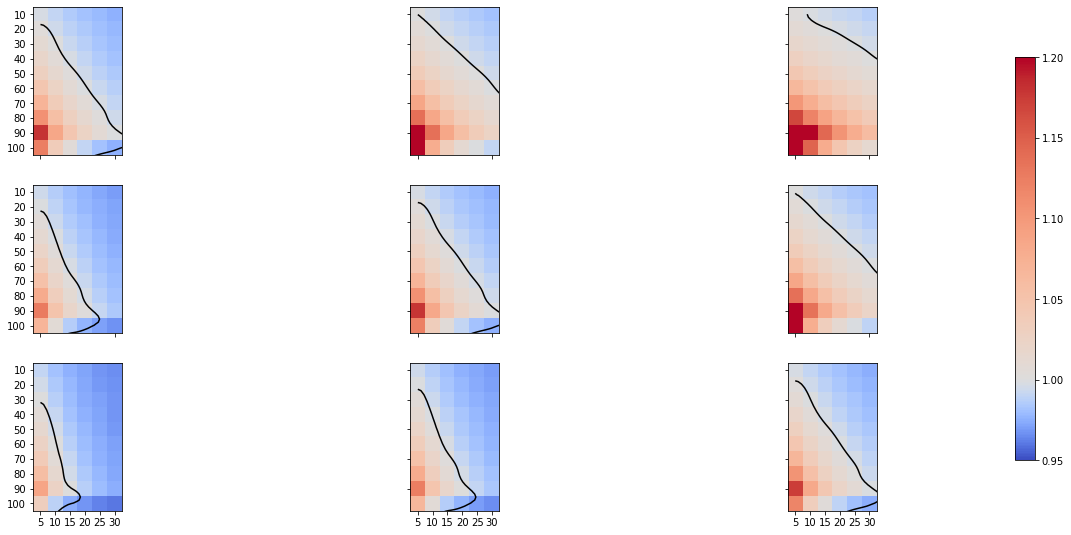

In [468]:
# Plot the ratio of total costs for the various values of the parameters investigated
# discount rates, damage level avoided through adaptation, costs of adaptation


# Define colorbar
colors1 = plt.cm.coolwarm(np.linspace(0, 1, 40))[:20]
colors2 = plt.cm.coolwarm(np.linspace(0, 1, 160))[-80:]
my_cmap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', np.vstack((colors1,colors2)))


## For the PW1.8 overshoot scenario

axes=[]
fig=plt.figure(figsize=(18,7))

xticklabels = []
for adc in range(len(adcosts_perc_dam)):
    xticklabels.append(str(adcosts_perc_dam[adc]))
    
yticklabels = []
for avd in range(len(perc_av_dam)):
    yticklabels.append(str(perc_av_dam[avd]))

    
smooth_scale = 5

for di in range(len(disc_rate)):
    for gr in range(len(ec_growth)):

        axes.append(fig.add_subplot(len(disc_rate), len(ec_growth), di*(len(ec_growth))+gr+1))
        
        z = ndimage.zoom(ratio_costs_options[3,di,gr,:,:], smooth_scale)
        cntr = plt.contour(np.linspace(0, len(adcosts_perc_dam), len(adcosts_perc_dam) * smooth_scale), 
                   np.linspace(0, len(perc_av_dam), len(perc_av_dam) * smooth_scale),
                   z, levels=(0.5,1), colors = 'black')
        
        ax = plt.imshow(ratio_costs_options[3,di,gr,:,:],cmap=my_cmap,vmin=0.95,vmax=1.2)

        if di != len(disc_rate)-1:
            ax.axes.xaxis.set_ticklabels([])
        else:
            plt.xticks(np.arange(len(adcosts_perc_dam)),xticklabels)
            
        if gr != 0:
            ax.axes.yaxis.set_ticklabels([])
        else:
            plt.yticks(np.arange(len(perc_av_dam)),yticklabels)
        

plt.subplots_adjust(bottom=0., right=0.95, top=1.0)
cax = plt.axes([0.97, 0.1, 0.015, 0.8])
plt.colorbar(cax=cax)



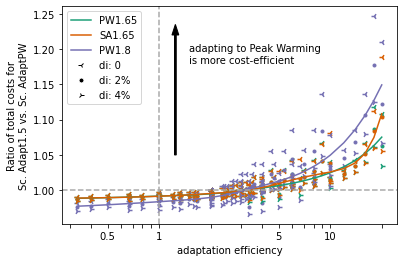

In [483]:
# CLEAN

# Plot the main figure of the box


## Re-order the array ratio_costs_options to have values for each adaptation efficiency value

ratio_reordered = np.empty([len(scens),len(disc_rate),len(ec_growth),len(perc_av_dam)*len(adcosts_perc_dam)])
ad_eff = np.empty(len(perc_av_dam)*len(adcosts_perc_dam))

for avd in range(len(perc_av_dam)):
    
    for adc in range(len(adcosts_perc_dam)):
        
        ratio_reordered[:,:,:,len(adcosts_perc_dam)*avd+adc] = ratio_costs_options[:,:,:,avd,adc]
        ad_eff[len(adcosts_perc_dam)*avd+adc] = perc_av_dam[avd]/adcosts_perc_dam[adc]

        
## Fit splines to the data (only for discount and growth rates equal to 2%)

ind = np.argsort(ad_eff)

knot_numbers = 3 
q=np.linspace(0, 1, knot_numbers+2)[1:-1]
knots = np.quantile(ad_eff, q)

t1,c1,k1 = interpolate.splrep(ad_eff[ind], ratio_reordered[1,1,1,ind], t=knots)
t2,c2,k2 = interpolate.splrep(ad_eff[ind], ratio_reordered[2,1,1,ind], t=knots)
t3,c3,k3 = interpolate.splrep(ad_eff[ind], ratio_reordered[3,1,1,ind], t=knots)


## Create legend

legend_elements = [Line2D([0], [0], color='#1b9e77', label='PW1.65'),
                   Line2D([0], [0], color='#d95f02', label='SA1.65'),
                   Line2D([0], [0], color='#7570b3', label='PW1.8'),
                   Line2D([0], [0], marker='3', color='w', label='di: 0',
                          markeredgecolor='k', markersize=6),
                   Line2D([0], [0], marker='.', color='w', label='di: 2%',
                          markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='4', color='w', label='di: 4%',
                          markeredgecolor='k', markersize=6)]


## Plot the ratio of total costs for the 3 scenarios and 3 values of discount rate
## Economic growth set to 2%.

plt.figure()

plt.scatter(np.log10(ad_eff),ratio_reordered[1,0,1,:], color='#1b9e77', marker='3')
plt.scatter(np.log10(ad_eff),ratio_reordered[2,0,1,:], color='#d95f02', marker='3')
plt.scatter(np.log10(ad_eff),ratio_reordered[3,0,1,:], color='#7570b3', marker='3')

plt.scatter(np.log10(ad_eff),ratio_reordered[1,1,1,:], color='#1b9e77', marker='.')
plt.scatter(np.log10(ad_eff),ratio_reordered[2,1,1,:], color='#d95f02', marker='.')
plt.scatter(np.log10(ad_eff),ratio_reordered[3,1,1,:], color='#7570b3', marker='.')

plt.scatter(np.log10(ad_eff),ratio_reordered[1,2,1,:], color='#1b9e77', marker='4')
plt.scatter(np.log10(ad_eff),ratio_reordered[2,2,1,:], color='#d95f02', marker='4')
plt.scatter(np.log10(ad_eff),ratio_reordered[3,2,1,:], color='#7570b3', marker='4')

xticks = np.log10([0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10,20])
xticks_labels = ['','','0.5','','','','','1','','','','5','','','','','10','']
plt.xticks(ticks=xticks, labels=xticks_labels)

yfit1 = interpolate.BSpline(t1,c1,k1)(ad_eff[ind])
yfit2 = interpolate.BSpline(t2,c2,k2)(ad_eff[ind])
yfit3 = interpolate.BSpline(t3,c3,k3)(ad_eff[ind])
plt.plot(np.log10(ad_eff[ind]), yfit1, c='#1b9e77')
plt.plot(np.log10(ad_eff[ind]), yfit2, c='#d95f02')
plt.plot(np.log10(ad_eff[ind]), yfit3, c='#7570b3')

plt.xlabel('adaptation efficiency')
plt.ylabel('Ratio of total costs for\nSc. Adapt1.5 vs. Sc. AdaptPW')

plt.arrow(np.log(1.1),1.05,0,0.17, width=0.01, head_length=0.015, head_width=0.04, color='k')
plt.text(np.log10(1.5),1.18,'adapting to Peak Warming\nis more cost-efficient')

plt.legend(handles=legend_elements)

plt.axhline(1.00, color='darkgrey', linestyle='dashed')
plt.axvline(0.0, color='darkgrey', linestyle='dashed')

plt.savefig(fname="main_figure_box.pdf")
plt.show()

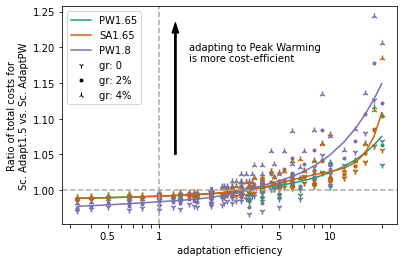

In [473]:
## Plot the ratio of total costs for the 3 scenarios and 3 values of economic growth rates
## Discount rate set to 2%.


legend2_elements = [Line2D([0], [0], color='#1b9e77', label='PW1.65'),
                   Line2D([0], [0], color='#d95f02', label='SA1.65'),
                   Line2D([0], [0], color='#7570b3', label='PW1.8'),
                   Line2D([0], [0], marker='1', color='w', label='gr: 0',
                          markeredgecolor='k', markersize=6),
                   Line2D([0], [0], marker='.', color='w', label='gr: 2%',
                          markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='2', color='w', label='gr: 4%',
                          markeredgecolor='k', markersize=6)]


plt.figure()

plt.scatter(np.log10(ad_eff),ratio_reordered[1,1,0,:], color='#1b9e77', marker='1')
plt.scatter(np.log10(ad_eff),ratio_reordered[2,1,0,:], color='#d95f02', marker='1')
plt.scatter(np.log10(ad_eff),ratio_reordered[3,1,0,:], color='#7570b3', marker='1')

plt.scatter(np.log10(ad_eff),ratio_reordered[1,1,1,:], color='#1b9e77', marker='.')
plt.scatter(np.log10(ad_eff),ratio_reordered[2,1,1,:], color='#d95f02', marker='.')
plt.scatter(np.log10(ad_eff),ratio_reordered[3,1,1,:], color='#7570b3', marker='.')

plt.scatter(np.log10(ad_eff),ratio_reordered[1,1,2,:], color='#1b9e77', marker='2')
plt.scatter(np.log10(ad_eff),ratio_reordered[2,1,2,:], color='#d95f02', marker='2')
plt.scatter(np.log10(ad_eff),ratio_reordered[3,1,2,:], color='#7570b3', marker='2')

plt.xticks(ticks=xticks, labels=xticks_labels)

plt.plot(np.log10(ad_eff[ind]), yfit1, c='#1b9e77')
plt.plot(np.log10(ad_eff[ind]), yfit2, c='#d95f02')
plt.plot(np.log10(ad_eff[ind]), yfit3, c='#7570b3')

plt.xlabel('adaptation efficiency')
plt.ylabel('Ratio of total costs for\nSc. Adapt1.5 vs. Sc. AdaptPW')

plt.arrow(np.log(1.1),1.05,0,0.17, width=0.01, head_length=0.015, head_width=0.04, color='k')
plt.text(np.log10(1.5),1.18,'adapting to Peak Warming\nis more cost-efficient')

plt.legend(handles=legend2_elements)

plt.axhline(1.00, color='darkgrey', linestyle='dashed')
plt.axvline(0.0, color='darkgrey', linestyle='dashed')

plt.savefig(fname="main_figure_box_growth.pdf")
plt.show()

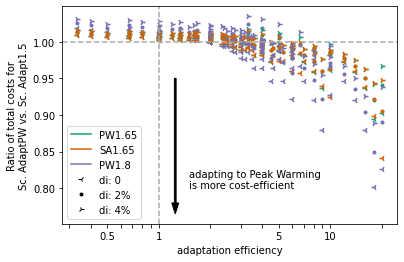

In [478]:
# Plot the ratio of costs as a function of adaptation efficiency

# VERSION WITH INVERTED RATIO (cost(Option2) / costs(Option1))


plt.figure()

plt.scatter(np.log10(ad_eff),1/ratio_reordered[1,0,1,:], color='#1b9e77', marker='3')
plt.scatter(np.log10(ad_eff),1/ratio_reordered[2,0,1,:], color='#d95f02', marker='3')
plt.scatter(np.log10(ad_eff),1/ratio_reordered[3,0,1,:], color='#7570b3', marker='3')

plt.scatter(np.log10(ad_eff),1/ratio_reordered[1,1,1,:], color='#1b9e77', marker='.')
plt.scatter(np.log10(ad_eff),1/ratio_reordered[2,1,1,:], color='#d95f02', marker='.')
plt.scatter(np.log10(ad_eff),1/ratio_reordered[3,1,1,:], color='#7570b3', marker='.')

plt.scatter(np.log10(ad_eff),1/ratio_reordered[1,2,1,:], color='#1b9e77', marker='4')
plt.scatter(np.log10(ad_eff),1/ratio_reordered[2,2,1,:], color='#d95f02', marker='4')
plt.scatter(np.log10(ad_eff),1/ratio_reordered[3,2,1,:], color='#7570b3', marker='4')


plt.xticks(ticks=xticks, labels=xticks_labels)

plt.xlabel('adaptation efficiency')
plt.ylabel('Ratio of total costs for\nSc. AdaptPW vs. Sc. Adapt1.5')

plt.arrow(np.log(1.1),0.95,0,-0.17, width=0.01, head_length=0.015, head_width=0.04, color='k')
plt.text(np.log10(1.5),0.8,'adapting to Peak Warming\nis more cost-efficient')

plt.legend(handles=legend_elements)

plt.axhline(1.00, color='darkgrey', linestyle='dashed')
plt.axvline(0.0, color='darkgrey', linestyle='dashed')

plt.show()

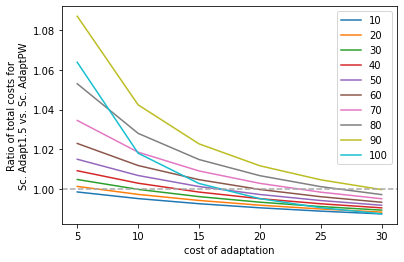

In [511]:
# Plot the ratio of costs as a function of cost of adaptation

plt.figure()

for avd in range(len(perc_av_dam)):

    # for scenario PW1.65, discount and growth rates set to 0
    plt.plot(adcosts_perc_dam,ratio_costs_options[1,0,0,avd,:], label=perc_av_dam[avd])


plt.axhline(1.00, color='darkgrey', linestyle='dashed')
plt.xlabel('cost of adaptation')
plt.ylabel('Ratio of total costs for\nSc. Adapt1.5 vs. Sc. AdaptPW')
plt.legend()

plt.show()

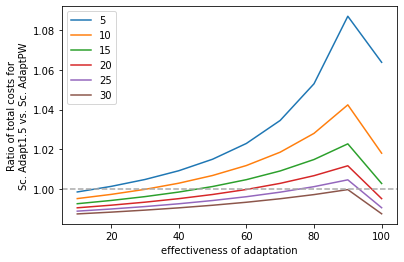

In [512]:
# Plot the ratio of costs as a function of adaptation effectiveness

plt.figure()

for adc in range(len(adcosts_perc_dam)):

    # for scenario PW1.65, discount and growth rates set to 0
    plt.plot(perc_av_dam,ratio_costs_options[1,0,0,:,adc], label=adcosts_perc_dam[adc])


plt.axhline(1.00, color='darkgrey', linestyle='dashed')
plt.xlabel('effectiveness of adaptation')
plt.ylabel('Ratio of total costs for\nSc. Adapt1.5 vs. Sc. AdaptPW')
plt.legend()

plt.show()

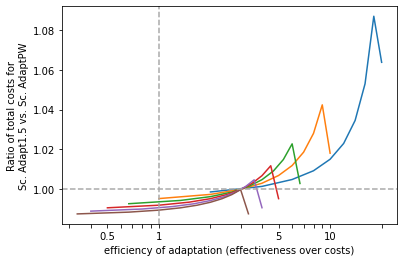

In [504]:
# Plot the ratio of costs as a function of adaptation efficiency

x = np.empty(len(perc_av_dam))
#for avd in range(len(perc_av_dam)):
#    x[avd] = perc_av_dam[avd]/adcosts_perc_dam[adc]

plt.figure()
     
for adc in [0, 1, 2, 3, 4, 5]:
        
    for avd in range(len(perc_av_dam)):
        x[avd] = perc_av_dam[avd]/adcosts_perc_dam[adc]
    
    plt.plot(np.log10(x),ratio_costs_options[1,0,0,:,adc], label=adcosts_perc_dam[adc])
        
plt.axhline(1.00, color='darkgrey', linestyle='dashed')
plt.axvline(0.0, color='darkgrey', linestyle='dashed')

plt.xticks(ticks=xticks, labels=xticks_labels)
plt.xlabel('efficiency of adaptation (effectiveness over costs)')
plt.ylabel('Ratio of total costs for\nSc. Adapt1.5 vs. Sc. AdaptPW')
plt.show()

In [505]:
## OLD

# If paying for adaptation in 2050, and assuming a discount rate, 
# what are the avoided damages over the next 30 years and how do they compare to adapting to 2080 levels?

# Plot the total costs = costs of adaptation + damages - avoided damages 

dash_patterns=['solid','dotted','dashed','dashdot','solid']

# assuming damages evolve linearly with GW

disc_rate = [0,2,4] # discount rate

adcosts_perc_dam = 10 # adaptation costs amount to 10% of damages (similar to Bresch and Aznar-Siguan, 2021, GMD)
perc_av_dam = 30  # Percentage of the damages avoided through adaptation

adcosts_damlin = np.empty([2,3,len(lin_coeff)])
max_dam = np.empty((2,3,len(lin_coeff)))
min_dam = np.empty((2,3,len(lin_coeff)))


for di in range(len(disc_rate)):  # Loop on possible values for the discount rate

    # Case 1: adaptation to 2050 damage levels
    
    # costs of adaptation
    adcosts_damlin[0,:,:] = np.squeeze(adcosts_perc_dam/100*dam_coeff_lin[:,:,np.where(years==2050)[0]])

    # max. damages: if 30-year event in 2050, accounting for avoided damages
    dam_lin = dam_coeff_lin[:,:,np.where(years==2050)[0]]
    av_dam_lin = perc_av_dam/100*dam_coeff_lin[:,:,np.where(years==2050)[0]]
    max_dam[0,:,:] = np.squeeze(dam_lin - av_dam_lin)
    #print(max_dam_case1)
    
    # min. damages: if 30-year event in 2080, accounting for avoided damages
    dam_lin = dam_coeff_lin[:,:,np.where(years==2080)[0]]
    min_dam[0,:,:] = np.squeeze((dam_lin - av_dam_lin)*(1-disc_rate[di]/100)**(2080-2050))
    #min_dam[0,:,:] = np.squeeze((1-perc_av_dam/100)*dam_coeff_lin[:,:,np.where(years==2050)[0]]*(1-disc_rate[di]/100)**(2080-2050))
    #print(min_dam_case1)
    
    
    # Case 2: adapt to 2080 damage levels

    # costs of adaptation
    adcosts_damlin[1,:,:] = np.squeeze(adcosts_perc_dam/100*dam_coeff_lin[:,:,np.where(years==2080)[0]])

    # max. damages: if 30-year event in 2050, accounting for avoided damages
    dam_lin = dam_coeff_lin[:,:,np.where(years==2050)[0]]
    av_dam_lin = perc_av_dam/100*dam_coeff_lin[:,:,np.where(years==2080)[0]]
    max_dam[1,:,:] = np.squeeze(dam_lin - av_dam_lin)
    #max_dam[1,:,:] = np.squeeze((1-perc_av_dam/100)*dam_coeff_lin[:,:,np.where(years==2080)[0]])
    
    # min. damages: if 30-year event in 2080, accounting for avoided damages
    dam_lin = dam_coeff_lin[:,:,np.where(years==2080)[0]]
    min_dam[1,:,:] = np.squeeze((dam_lin - av_dam_lin)*(1-disc_rate[di]/100)**(2080-2050))
    #min_dam[1,:,:] = np.squeeze((1-perc_av_dam/100)*dam_coeff_lin[:,:,np.where(years==2080)[0]]*(1-disc_rate[di]/100)**(2080-2050))
    
   
    # PLOT RESULTS
    
    totalcosts_max = np.empty([2,3*len(lin_coeff)])
    totalcosts_min = np.empty([2,3*len(lin_coeff)])                                                        
                                                        
    for i in range(3):
        for j in range(len(lin_coeff)):
            totalcosts_max[0,i*len(lin_coeff)+j] = adcosts_damlin[0,i,j] + max_dam[0,i,j]
            totalcosts_min[0,i*len(lin_coeff)+j] = adcosts_damlin[0,i,j] + min_dam[0,i,j]                                                       
            totalcosts_max[1,i*len(lin_coeff)+j] = adcosts_damlin[1,i,j] + max_dam[1,i,j]
            totalcosts_min[1,i*len(lin_coeff)+j] = adcosts_damlin[1,i,j] + min_dam[1,i,j]
    
    plt.figure()
    labels = ['Sc. 1, coeff. 1', 'Sc. 1, coeff. 2', 'Sc. 2, coeff. 1', 'Sc. 2, coeff. 2', 'Sc. 3, coeff. 1', 'Sc. 3, coeff. 2']
    X = np.arange(len(labels))
    p1 = plt.bar(X + 0.00, totalcosts_max[0,:], width = 0.25, color=['C0','C0','C1','C1','C2','C2'], hatch="/", edgecolor='black')
    p2 = plt.bar(X + 0.25, totalcosts_max[1,:], width = 0.25, color=['C0','C0','C1','C1','C2','C2'], hatch="/", edgecolor='black')
    plt.bar(X + 0.00, totalcosts_min[0,:], width = 0.25, color=['C0','C0','C1','C1','C2','C2'], edgecolor='black')
    plt.bar(X + 0.25, totalcosts_min[1,:], width = 0.25, color=['C0','C0','C1','C1','C2','C2'], edgecolor='black')
    
    plt.bar_label(p1, labels=['1','1','1','1','1','1'])
    plt.bar_label(p2, labels=['2','2','2','2','2','2'])
    plt.xticks(X, labels, rotation=45)
    plt.ylabel('costs of adaptation + damages')
    plt.title('Discount rate: '+str(disc_rate[di])+'%')
    plt.show()
    
                                                              
    # plot cumulated avoided damages if adapting in 2050 to 2050 damage levels
        #av_damlin = np.zeros(3,5,(years[np.where(years == 2050)]-years[np.where(years == 2080)])/step_yr+1)
#        plt.figure()
#        for i in range(len(lin_coeff)):
#            for yr in range(1,int((2080-2050)/step_yr+1)):
#                av_damlin[0,i,yr] = av_damlin[0,i,yr-1] + perc_av_dam*dam_coeff_lin[0,i,np.where(years==2050)[0]+yr]*value[np.where(years==2050)[0]+yr]*(1-disc_rate[di]**yr/100)
#                av_damlin[1,i,yr] = av_damlin[1,i,yr-1] + perc_av_dam*dam_coeff_lin[1,i,np.where(years==2050)[0]+yr]*value[np.where(years==2050)[0]+yr]*(1-disc_rate[di]**yr/100)
#               av_damlin[2,i,yr] = av_damlin[2,i,yr-1] + perc_av_dam*dam_coeff_lin[2,i,np.where(years==2050)[0]+yr]*value[np.where(years==2050)[0]+yr]*(1-disc_rate[di]**yr/100)
                
            #print(years[np.where(years==2050)[0]:])
#            plt.plot(years[int((2050-years[0])/step_yr):int((2080-years[0])/step_yr)+1],av_damlin[0,i,:], color='C0', linestyle=dash_patterns[i])
#            plt.plot(years[int((2050-years[0])/step_yr):int((2080-years[0])/step_yr)+1],av_damlin[1,i,:], color='C1', linestyle=dash_patterns[i])
#            plt.plot(years[int((2050-years[0])/step_yr):int((2080-years[0])/step_yr)+1],av_damlin[2,i,:], color='C2', linestyle=dash_patterns[i])
            
#        plt.title('damages: linear, economic growth: '+str(ec_growth[gr])+'%, discount rate: '+str(disc_rate[di])+'%')
#        plt.xlabel('time (yr)')
#        plt.ylabel('avoided cumulative damages if adapting to 2050 levels')
#        plt.show()
        
        ### 

NameError: name 'lin_coeff' is not defined

In [51]:
# Define GMT scenarios

scens = ["stabil_15", "PW_16", "PW_17", "PW_18"]

PW = [1.5, 1.6, 1.7, 1.8]
yr_start = 2020
yr_15_befov = 2040
yr_PW = 2060
yr_15_aftov = 2080

GMT=np.zeros((len(scens),len(years)))

for sc in range(len(scens)):
    for i in range(len(years)):
        if years[i] <= yr_15_befov:
            GMT[sc,i] = 1.5 - (yr_15_befov-years[i])*(1.5-1.2)/(yr_15_befov-yr_start)
        if years[i] > yr_15_befov and years[i] <= yr_PW:       
            GMT[sc,i] = PW[sc] - (yr_PW-years[i])*(PW[sc]-1.5)/(yr_PW-yr_15_befov)
        elif years[i] > yr_PW and years[i] <= yr_15_aftov:
            GMT[sc,i] = PW[sc] - (years[i]-yr_PW)*(PW[sc]-1.5)/(yr_15_aftov-yr_PW)
        elif years[i] > 2060:
            GMT[sc,i] = 1.5

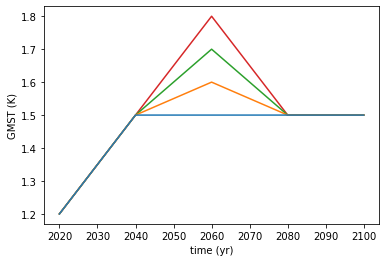

In [52]:
# Plot the GMT trajectories
    
plt.plot(years,GMT[3,:], color='C3')
plt.plot(years,GMT[2,:], color='C2')
plt.plot(years,GMT[1,:], color='C1')
plt.plot(years,GMT[0,:], color='C0')
    
plt.xlabel('time (yr)')
plt.ylabel('GMST (K)')
plt.show()